# Подключаем нужные библиотеки

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

%matplotlib inline

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [2]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [3]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [16]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 199 ms, sys: 8.55 ms, total: 207 ms
Wall time: 212 ms


По умолчанию матрица $A$ хранится в формате $\texttt{csr_matrix}$

In [5]:
denseA = A.toarray()
print(type(A))
print(type(denseA))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


Насэмплируем индексов для батчей

In [6]:
%%time
batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)

CPU times: user 59.2 s, sys: 374 ms, total: 59.6 s
Wall time: 59.7 s


Пример того, как выглядят тесты для полноградиентного случая

In [7]:
%%time
x = norm_d.rvs(size=n)

CPU times: user 170 µs, sys: 21 µs, total: 191 µs
Wall time: 195 µs


In [8]:
num_of_tests = 600

In [9]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [A, y, 0, True])

CPU times: user 6.27 s, sys: 35.4 ms, total: 6.31 s
Wall time: 6.32 s


In [10]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [denseA, y, 0, False])

CPU times: user 44.8 s, sys: 1.52 s, total: 46.3 s
Wall time: 11.9 s


Пример тестов для случая стох. градиентов

In [11]:
batch_size = 1
num_of_tests = 10000

In [12]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])

CPU times: user 17.1 s, sys: 86.3 ms, total: 17.2 s
Wall time: 17.1 s


In [13]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])

CPU times: user 483 ms, sys: 5 ms, total: 488 ms
Wall time: 485 ms


Зафиксируйте здесь результаты своих экспериментов:

In [47]:
def test_dataset(dataset = "a9a",num_of_tests=100):     
    A, y, m, n, sparsity_A = prepare_data(dataset)
    L, average_L, worst_L = compute_L(dataset, A)
    denseA = A.toarray()
    batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)
    start_gd_A = time.time() 
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            logreg_grad(x, [A, y, 0, True])
    elapsed_gd_A = time.time() - start_gd_A
    start_gd_denseA = time.time()    
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            logreg_grad(x, [denseA, y, 0, False])
    elapsed_gd_denseA = time.time() - start_gd_denseA
            
    batch_size = 1
    num_of_tests *= 10
    elapsed_sgd_A =[]
    elapsed_sgd_denseA = []
    for batch_size in [1,10,100]:
        start_sgd_A = time.time() 
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])
        elapsed_sgd_A.append(time.time() - start_sgd_A)
        start_sgd_denseA = time.time() 

        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])
        elapsed_sgd_denseA.append(time.time() - start_sgd_denseA)
    
    return {'Dataset':dataset,'M':m,'N':n,'L':L,'average_L':average_L,'worst_L':worst_L,
            'sparsity_A':sparsity_A,'GD Time A':elapsed_gd_A,'GD Time denseA':elapsed_gd_denseA,
            'SGD Time A 1':elapsed_sgd_A[0],'SGD Time denseA 1':elapsed_sgd_denseA[0],
            'SGD Time A 10':elapsed_sgd_A[1],'SGD Time denseA 10':elapsed_sgd_denseA[1],
            'SGD Time A 100':elapsed_sgd_A[2],'SGD Time denseA 100':elapsed_sgd_denseA[2]}

In [23]:
res = test_dataset()
res

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716


In [48]:
sets = ['a9a','gisette','australian','breast-cancer','german_numer']
nums = [500,100,2000,4000,1000]

In [49]:
df=[]
for dtset,n in zip(sets,nums):
    df.append(test_dataset(dtset,n))
    

In [50]:
results = pd.DataFrame(df)
results

,Dataset,GD Time A,GD Time denseA,L,M,N,SGD Time A 1,SGD Time A 10,SGD Time A 100,SGD Time denseA 1,SGD Time denseA 10,SGD Time denseA 100,average_L,sparsity_A,worst_L
0,a9a,4.709890,10.708629,1.571920e+00,32561,123,7.765888,7.962880,8.477651,0.233217,0.305211,1.004957,3.467277e+00,0.112757,3.500000e+00
1,gisette,106.869208,14.787198,8.428680e+02,6000,5000,1.859524,3.305516,21.072244,0.135006,0.390578,4.424257,1.163345e+03,0.991000,1.201509e+03
2,australian,1.380899,0.269991,7.036285e+06,690,14,31.338684,31.332407,33.304950,0.831799,0.920130,1.280808,7.051932e+06,0.799586,2.500101e+09
3,breast-cancer,2.506657,0.324227,3.859904e+11,683,10,62.304416,63.979224,65.619218,1.720952,1.794637,2.494988,3.859904e+11,1.000000,4.525490e+13
4,german_numer,0.889530,0.171659,8.436612e+02,1000,24,15.609691,15.952263,17.070933,0.418726,0.463160,0.641030,9.798927e+02,0.749542,9.305750e+03


В целом - dense всегда быстрее, кроме одного случая. Могу предположить, что это связано с значением sparsity, которое оказалось наиболее близким к нулю. Ну... либо эксперимент не особо удался.

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [4]:
#напишите код в этой ячейке
def prox_R(x, lamb):
    return np.sign(x) * np.maximum(np.abs(x)- lamb, 0)

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [5]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можн гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [5]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 170 ms, sys: 10.8 ms, total: 181 ms
Wall time: 176 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [57]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

CPU times: user 5.8 s, sys: 34.5 ms, total: 5.83 s
Wall time: 5.83 s


array([29699,  2169,  1732, ...,  1267, 27788,  6079])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [ ]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [6]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [7]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.8 s, sys: 119 ms, total: 1.92 s
Wall time: 1.06 s


Запустите функцию, тестирующую корректность работы

In [8]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [12]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'L-SVRG':
        with open('dump/'+filename+'_L-SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_prob_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SAGA':
        with open('dump/'+filename+'_SAGA_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [13]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [14]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [12]:
# ваш код здесь
# задать параметры
test_indices = None
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [13]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.3578568111141975
Процент ненулевых координат в найденном решении:  0.2845528455284553
CPU times: user 7min 54s, sys: 17.7 s, total: 8min 11s
Wall time: 5min 49s


In [14]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [15]:
%%time
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.357986
         Iterations: 185
         Function evaluations: 257
         Gradient evaluations: 251
0.3579855634164814
CPU times: user 3.3 s, sys: 327 ms, total: 3.63 s
Wall time: 994 ms


In [17]:
l1 = 0

In [18]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.32527803015192985
Процент ненулевых координат в найденном решении:  1.0
CPU times: user 7min 58s, sys: 17.7 s, total: 8min 15s
Wall time: 5min 53s


In [19]:
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

In [20]:
%%time
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.325278
         Iterations: 581
         Function evaluations: 585
         Gradient evaluations: 584
0.32527803015194184
CPU times: user 8.27 s, sys: 813 ms, total: 9.08 s
Wall time: 2.28 s


Найденные значения близки, но время, ушедшее на расчеты... Может, ошибаюсь с форматом, опять же.

Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [22]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [24]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2.96 s, sys: 114 ms, total: 3.07 s
Wall time: 2.21 s


Следующая функция позволяет строить графики

In [20]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'sampled_grads':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

In [26]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

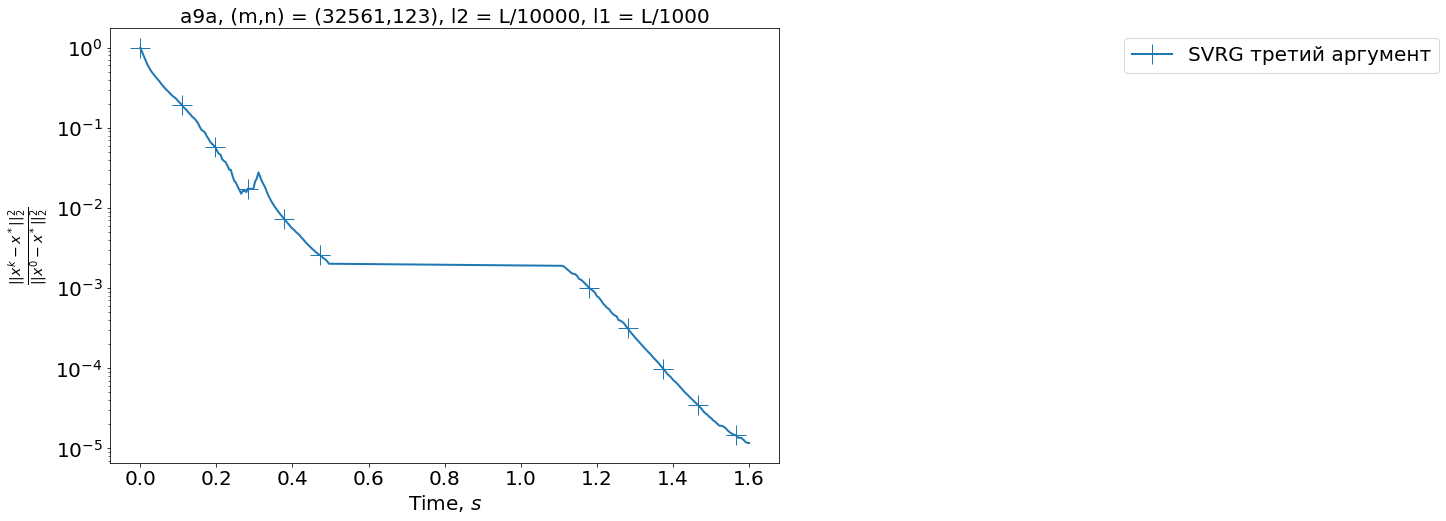

In [27]:
make_plots(args=args_for_plots)

Посчитаем для дальнейших экспериментов.

In [14]:
%%time
for l2_ in[L/100000,L/10000,L/1000]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = l2_
    l1 = L / 1000
    batch_size = 10
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = None
    f_star = None
    S = 1000
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

CPU times: user 47min 15s, sys: 1min 40s, total: 48min 55s
Wall time: 34min 37s


Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

In [11]:
for r in[1,10,100]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

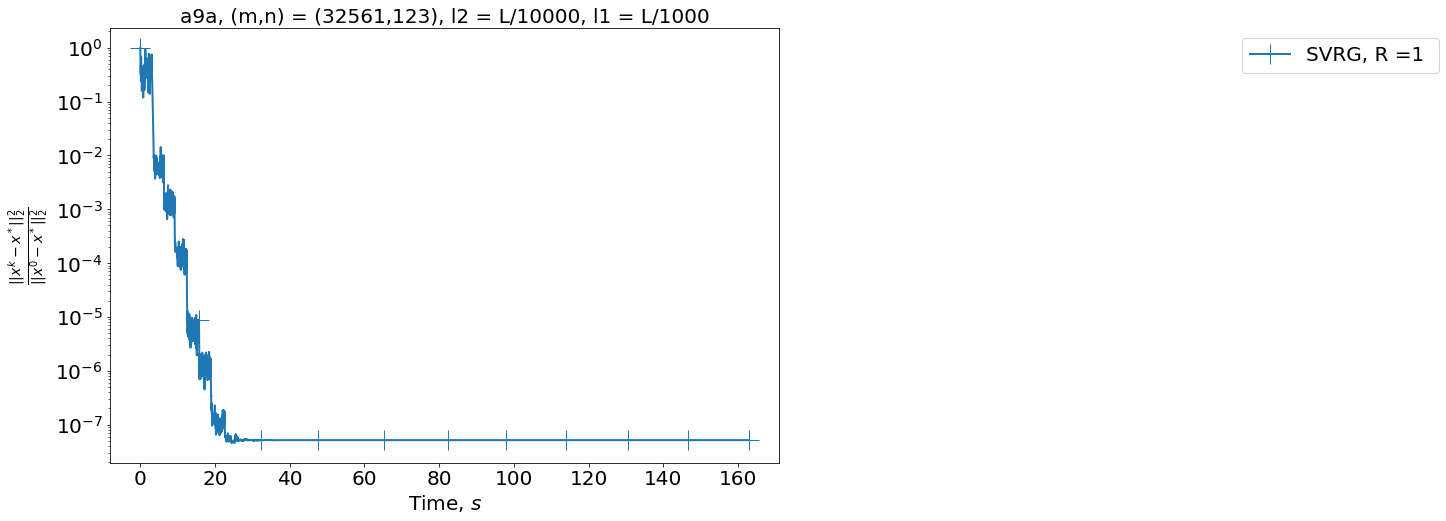

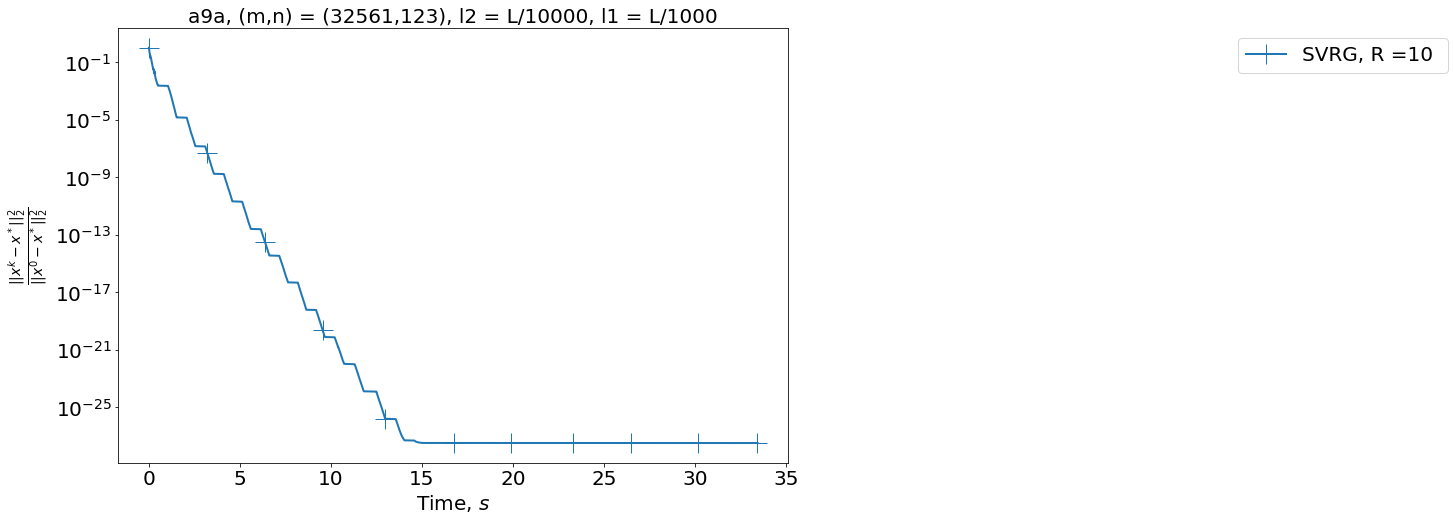

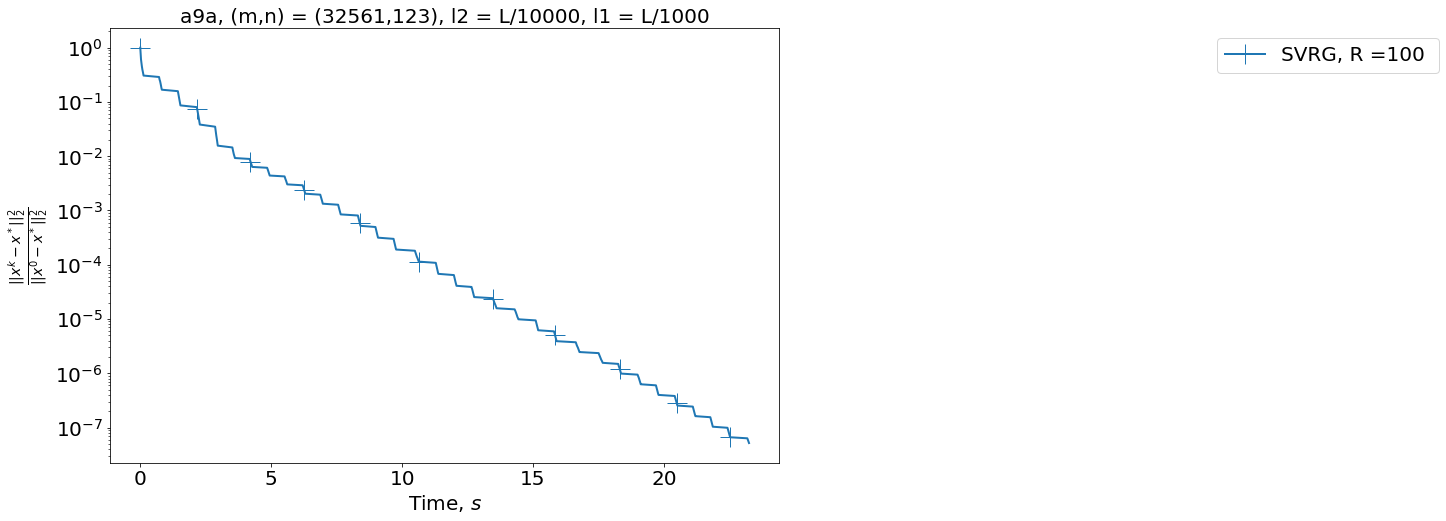

In [12]:
for r in[1,10,100]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    gamma = 1.0/(6*(L+l2))
    methods = [
             ['SVRG', [gamma, l2, l1, S, int(2*m/batch_size), r], 
               f', R ={r} ', None],
    ]
    mode_y = 'squared_distances'
    mode_x = 'time'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

In [17]:
for l2_ in[L/100000,L/10000,L/1000]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = l2_
    l1 = L / 1000
    batch_size = 10
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 40
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    #save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

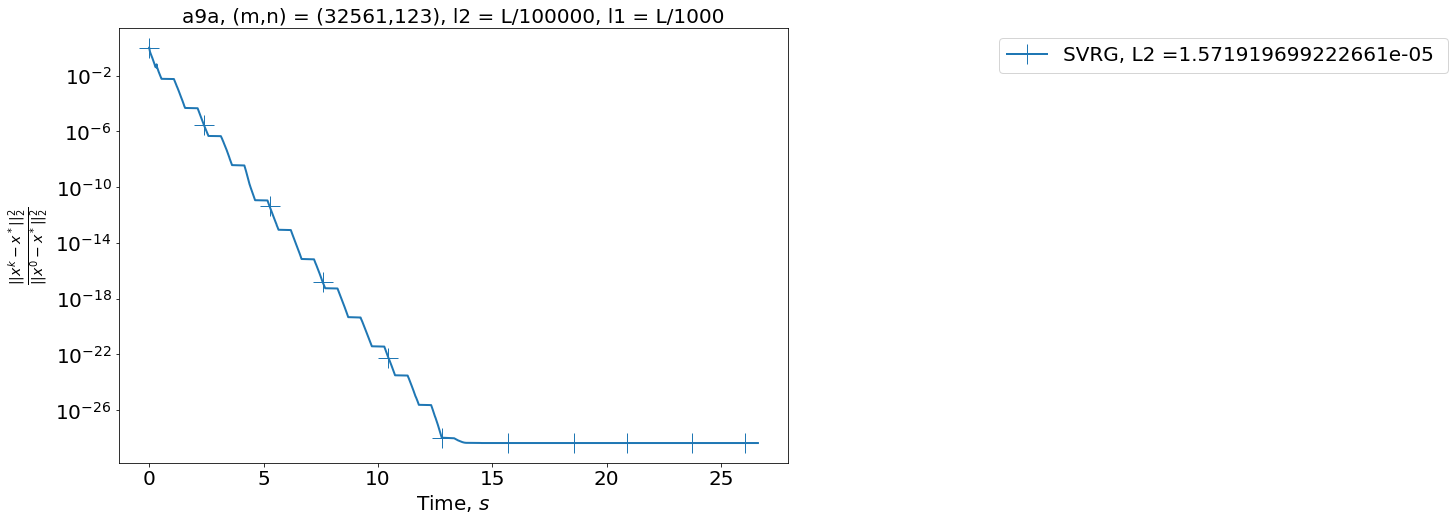

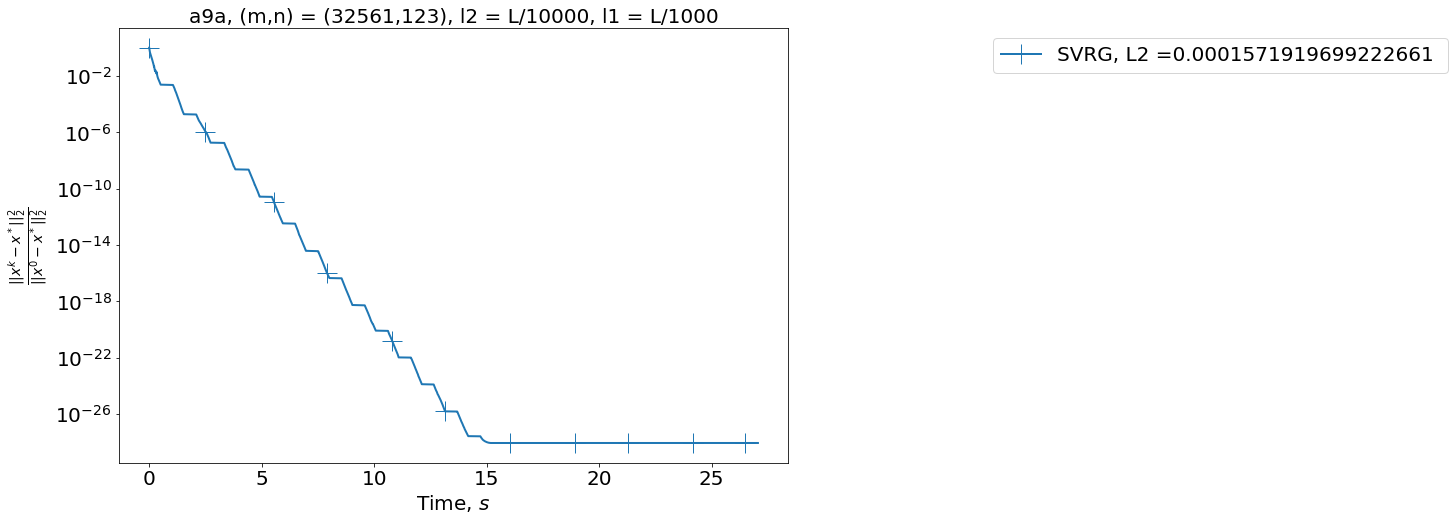

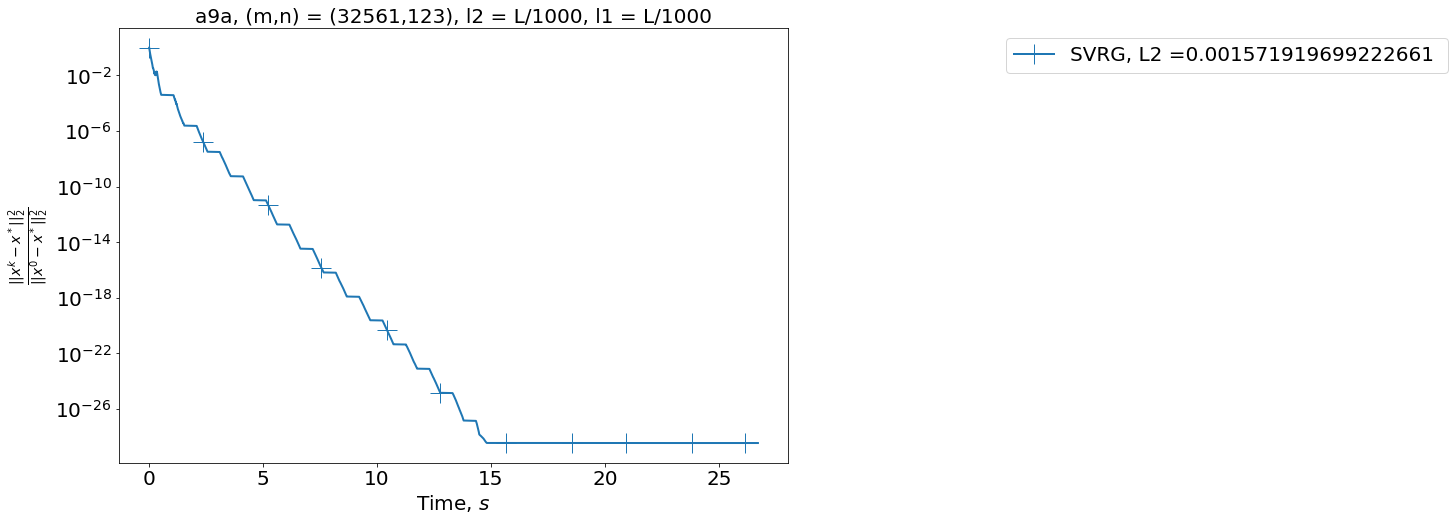

In [18]:
for l2_ in[L/100000,L/10000,L/1000]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = l2_
    l1 = L / 1000
    batch_size = 10
    gamma = 1.0/(6*(L+l2))
    methods = [
             ['SVRG', [gamma, l2, l1, S, int(2*m/batch_size), 10], 
               f', L2 ={l2_} ', None],
    ]
    mode_y = 'squared_distances'
    mode_x = 'time'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

In [ ]:
for l2_ in[L/100000,L/10000,L/1000]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = l2_
    l1 = L / 1000
    batch_size = 10
    gamma = 1.0/(6*(L+l2))
    methods = [
             ['SVRG', [gamma, l2, l1, S, int(2*m/batch_size), 10], 
               f', L2 ={l2_} ', None],
    ]
    mode_y = 'squared_distances'
    mode_x = 'time'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

Получилось, что есть разумные пределы для выбора параметров алгоритма, брать слишком большими и маленькими оказалось невыгодно. Правда, в точности самих экспериментов не совсем уверен.

## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [9]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [10]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 403 ms, sys: 9.45 ms, total: 413 ms
Wall time: 412 ms


Запустите функцию, тестирующую корректность работы

In [11]:
sgd_const_test(res)

Тесты пройдены!


0

In [12]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [13]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.31 s, sys: 5.33 ms, total: 1.32 s
Wall time: 1.32 s


Запустите функцию, тестирующую корректность работы

In [14]:
sgd_decr_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [27]:
for a in [1.0,0.1,0.01]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 10
    M = int(2*m/batch_size)
    gamma = a/((L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 15
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    #save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

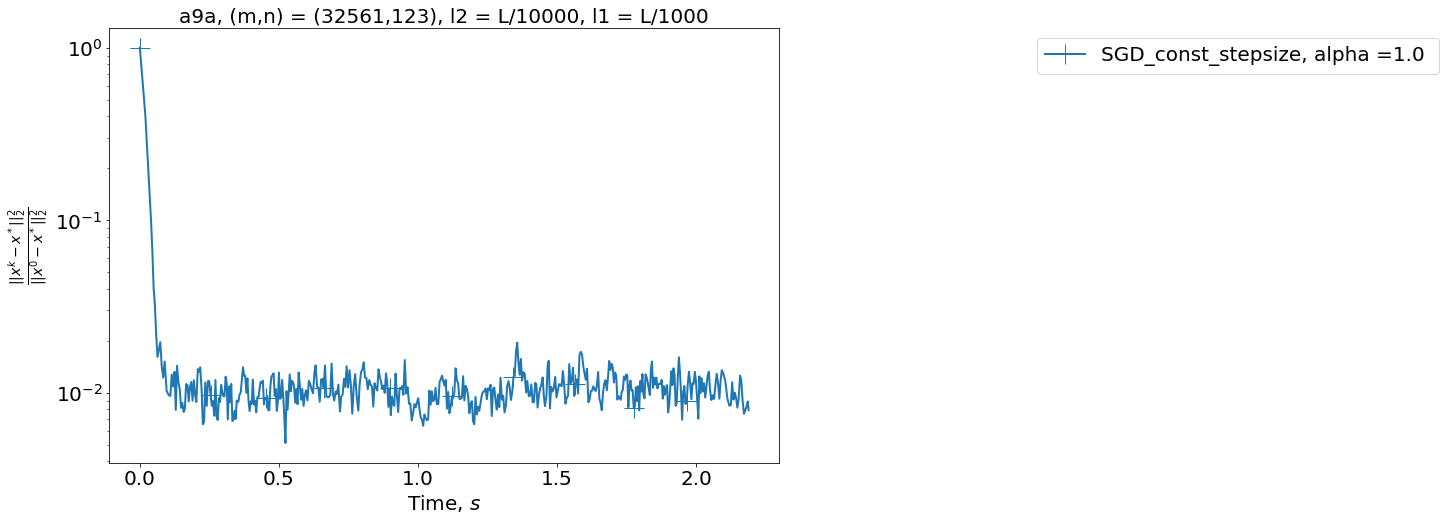

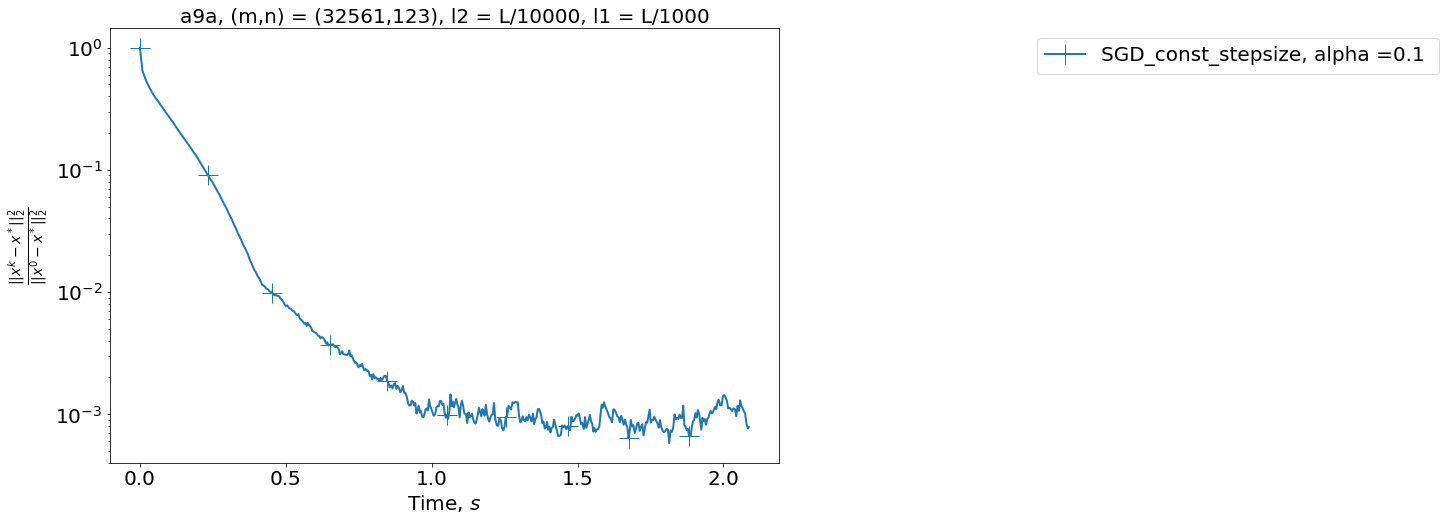

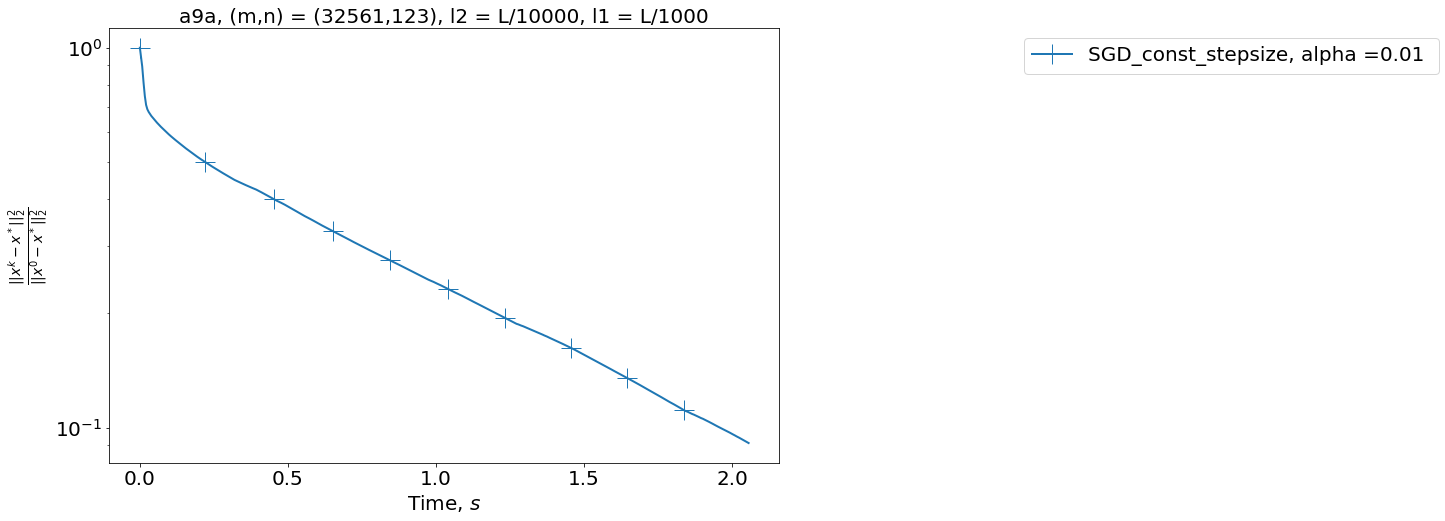

In [28]:
for a in [1.0,0.1,0.01]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 10
    M = int(2*m/batch_size)
    gamma = a/((L+l2))
    
    methods = [
             ['SGD_const_stepsize', [gamma, l2, l1, S, 10], 
               f', alpha ={a} ', None],
    ]
    mode_y = 'squared_distances'
    mode_x = 'time'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

Можно заметить, что при большом значении $\alpha$ заметна осцилляция. При наименьшем значении происходит постоянное приблежение к $x^*$, но находимся мы на большем расстоянии от него.

In [33]:
for schedule in [[gamma, 1, 0.5],[gamma, 3, 0.5],[gamma, 5, 0.1],[gamma, 1, 0.8]]:
    filename=dataset+"_x_init_all_ones"
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 10
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    gamma_schedule = schedule
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 10
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

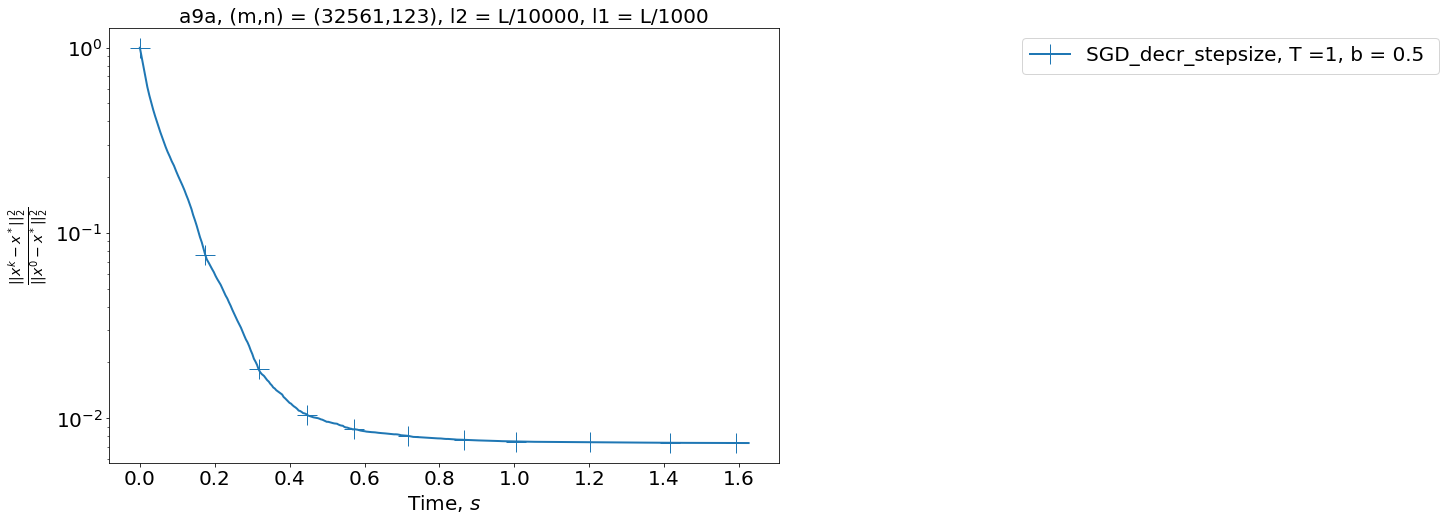

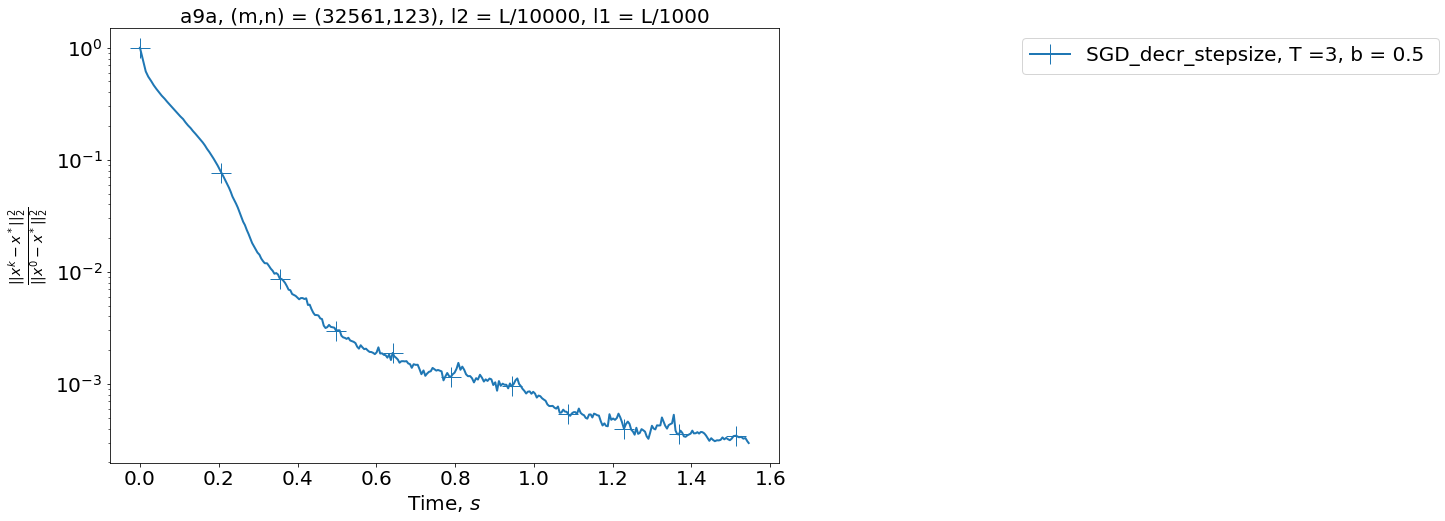

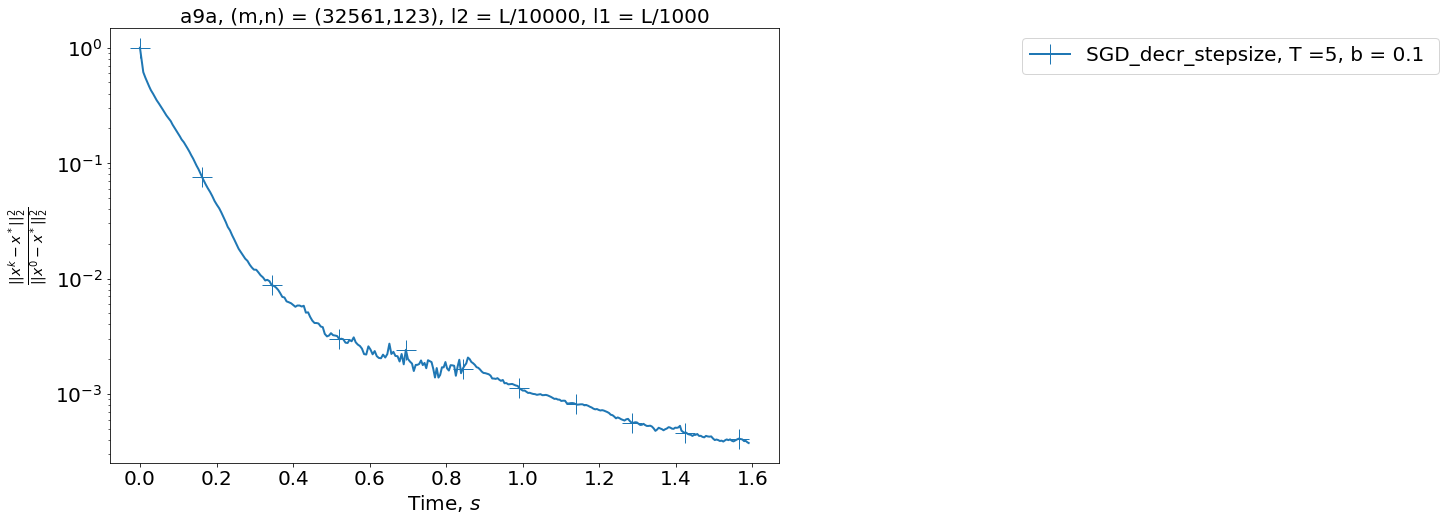

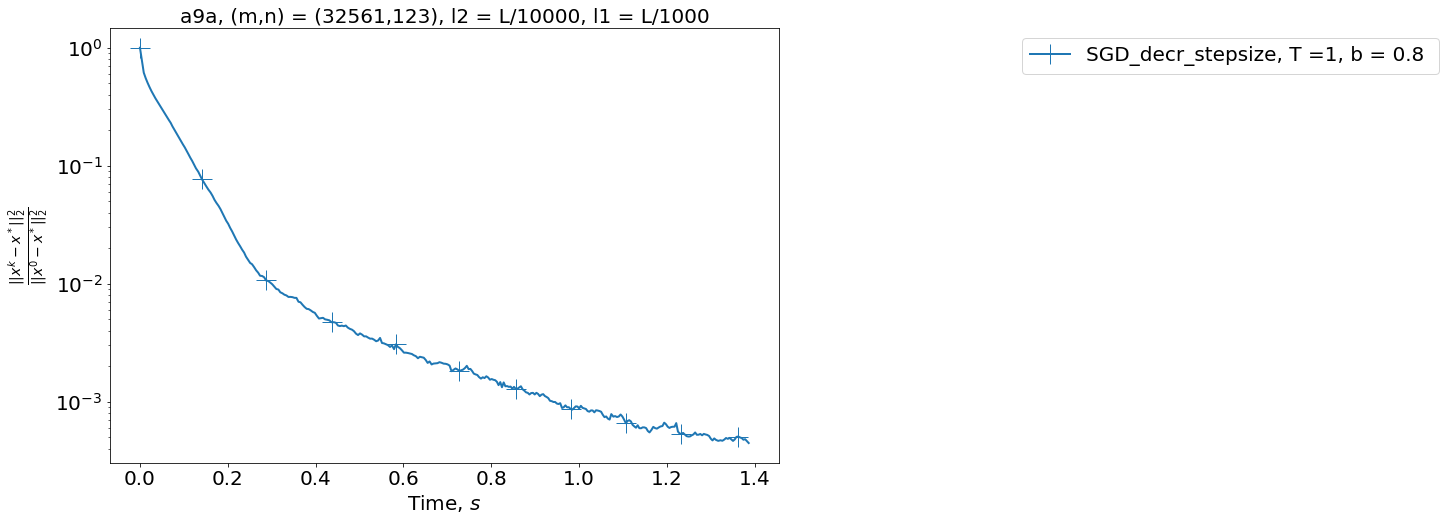

In [35]:
for schedule in [[gamma, 1, 0.5],[gamma, 3, 0.5],[gamma, 5, 0.1],[gamma, 1, 0.8]]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 10
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    gamma_schedule = schedule
    S = 10
    save_info_period = 100
    
    methods = [
             ['SGD_decr_stepsize', [schedule, l2, l1, S, 10], 
               f', T ={schedule[1]}, b = {schedule[2]} ', None],
    ]
    mode_y = 'squared_distances'
    mode_x = 'time'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

Чем чаще мы сокращаем размер шага, тем чаще изменяет свой "наклон" кривая на графиках. Так мы избегаем ситуации, когда мы "перепрыгиваем" $x^*$, однако, если уменьшать шаг слишком сильно, то мы рискуем просто напросто не дойти до этого решения, хотя и избежали осцилляции. Как всегда, нужно выбирать какие-то разумные значения.

## Задание 5. L-SVRG и SAGA

Имплементируйте $\texttt{prox-L-SVRG}$ с мини-батчингом и $\texttt{prox-SAGA}$ мини-батчингом.

Для $\texttt{prox-L-SVRG}$ для тестирования корректности используйте заранее насэмплированную выборку bernoulli_exp из распределения Бернулли с нужным параметром. Этот массив нужен, чтобы определять, нужно ли обновлять $w$ на текущей итерации или нет. Если обновляется $w$, то нужно пересчитать полный градиент в точке $w$, чтобы потом его можно было использовать. Как и в случае сэмплирования индексов для выбора слагаемых, гораздо быстрее сгенерировать выборку некоторого размера $N$ из распределения Бернулли, чем сэмплировать $N$ раз, поэтому предлагается периодически сэмплировать выборку из распределения Бернулли некоторого разумного размера, нежели сэмплировать выборку размера $1$ на каждой итерации. Кроме того, возможность передавать массив bernoulli_exp в метод введена для того, чтобы можно было проконтроллировать правильность работы Вашей имплементации, т.к. в таком случае для метода заранее определено (на первых len(bernoulli_exp) итерациях), в какие моменты происходит обновление $w$.

In [5]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)
with open("dump/bernoulli_test.txt", 'rb') as file:
    bernoulli_exp = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
p = 1.0*batch_size / m
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [6]:
%%time
res = l_svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, p=p, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, bernoulli_exp=bernoulli_exp,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2min 52s, sys: 4.68 s, total: 2min 57s
Wall time: 44.6 s


Запустите функцию, тестирующую корректность работы

In [7]:
l_svrg_test(res)

Некорректная последняя точка


1

In [ ]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [ ]:
%%time
res = saga(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
saga_test(res)

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

## Задание 6. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [7]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [8]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2.11 s, sys: 10.2 ms, total: 2.12 s
Wall time: 2.13 s


Запустите функцию, тестирующую корректность работы

In [9]:
prox_gd_test(res)

Тесты пройдены!


0

In [10]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = False

In [11]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.32 s, sys: 5.03 ms, total: 1.32 s
Wall time: 1.32 s


In [12]:
with open("dump/fista_test.txt", 'rb') as file:
        true_result = pickle.load(file)

In [13]:
from numpy.linalg import norm

In [14]:
norm(res['last_iter']-true_result['last_iter'])

5.596316626695313e-06

Запустите функцию, тестирующую корректность работы

In [10]:
fista_test(res)

Некорректная последняя точка


1

Немного не прохожу тест, но, вроде как, все ок.

In [5]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = False

In [6]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.5 s, sys: 6.6 ms, total: 1.51 s
Wall time: 1.51 s


In [7]:
with open("dump/gd_test.txt", 'rb') as file:
        true_result = pickle.load(file)

norm(res['last_iter']-true_result['last_iter'])

1.1142736556828212e-15

Запустите функцию, тестирующую корректность работы

In [8]:
gd_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

Оценка для FISTA может быть получена из формулы из 6 лекции. Правда, там я нашел лишь информацию про количество итераций, но не про другие параметры.

In [ ]:
x_init = np.ones(n)

In [36]:
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
delta_f = res['func_vals'][0]-f_star
epsilon=10**-8
S=np.sqrt(L/l2)*np.log((delta_f+l2*res['squared_distances'][0])/epsilon)

In [37]:
S

2072.5625468956546

In [38]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
S = int(S)
save_info_period = 10
sparse = False
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

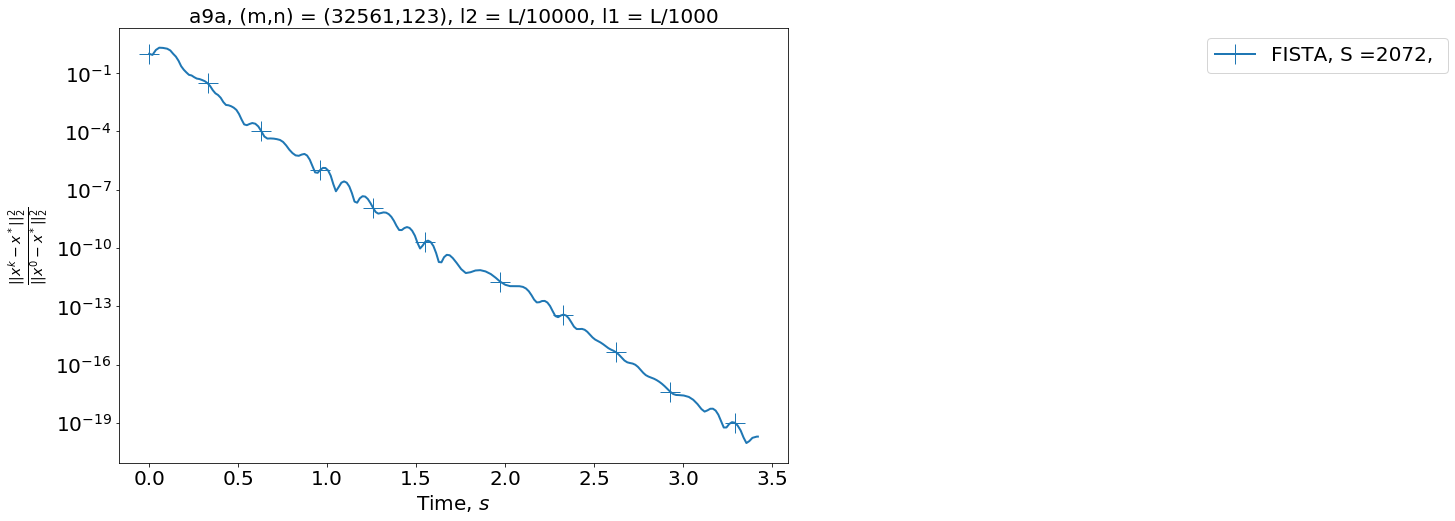

In [39]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

Как-то быстрее все это сработало..

In [46]:
S = int (L*123/epsilon)

In [47]:
S

19334612300

Не очень нравится такое количество итераций....но, тем не менее..

In [54]:
S = 4000
S

4000

In [55]:
gamma = 1/L
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

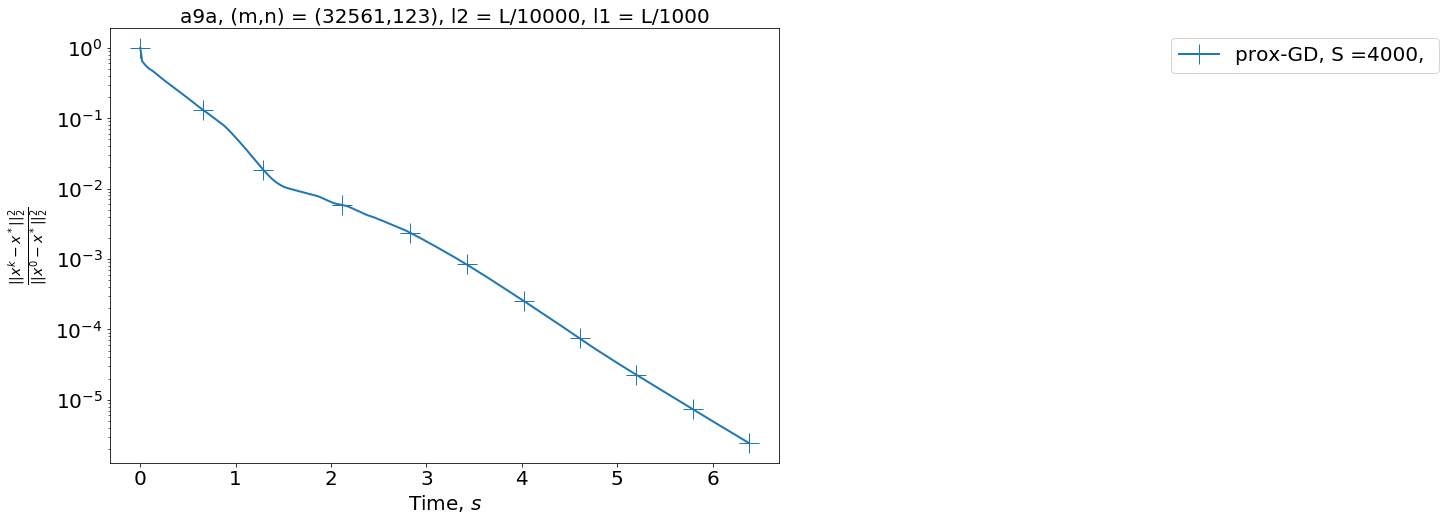

In [56]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

Заметно, что метод сходится медленнее, чем FISTA.

In [62]:
for gam in [0.1,0.05,1.5,2.,2.3,2.5,2.8,3,3.1]:
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    gamma = gam/((L+l2))
    S = 4000
    save_info_period = 10
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)

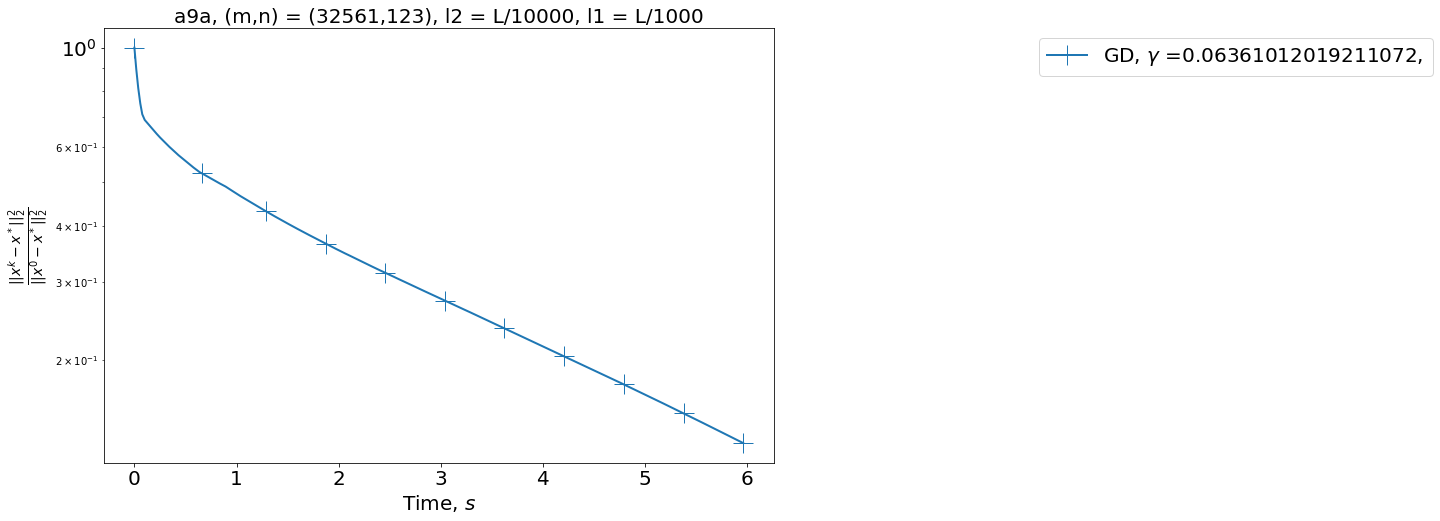

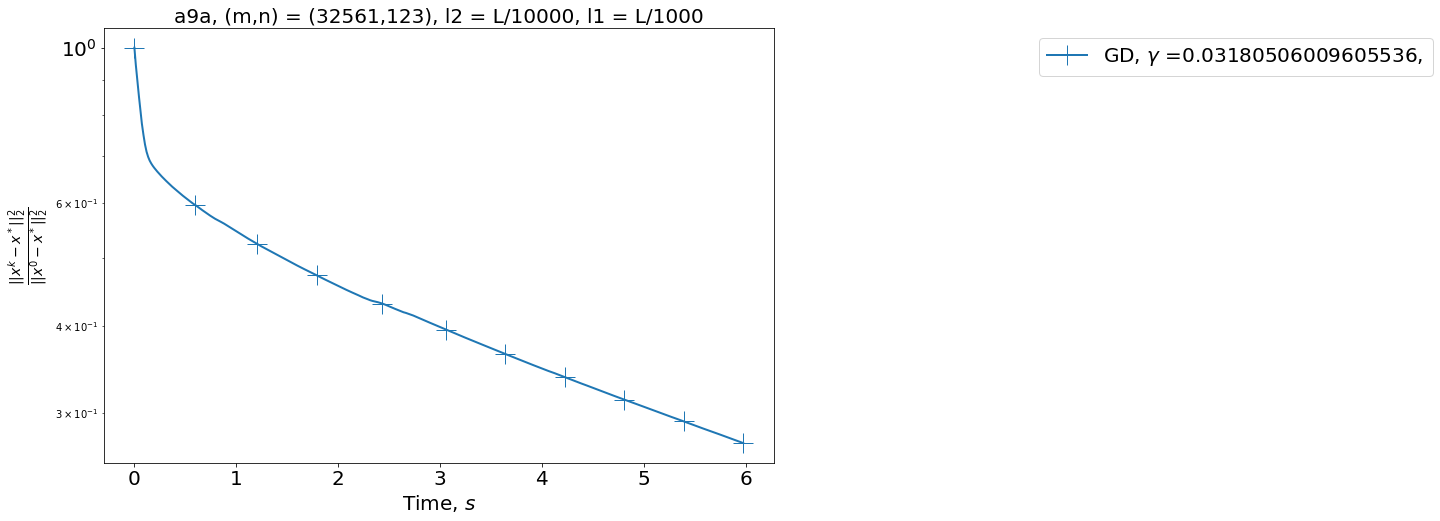

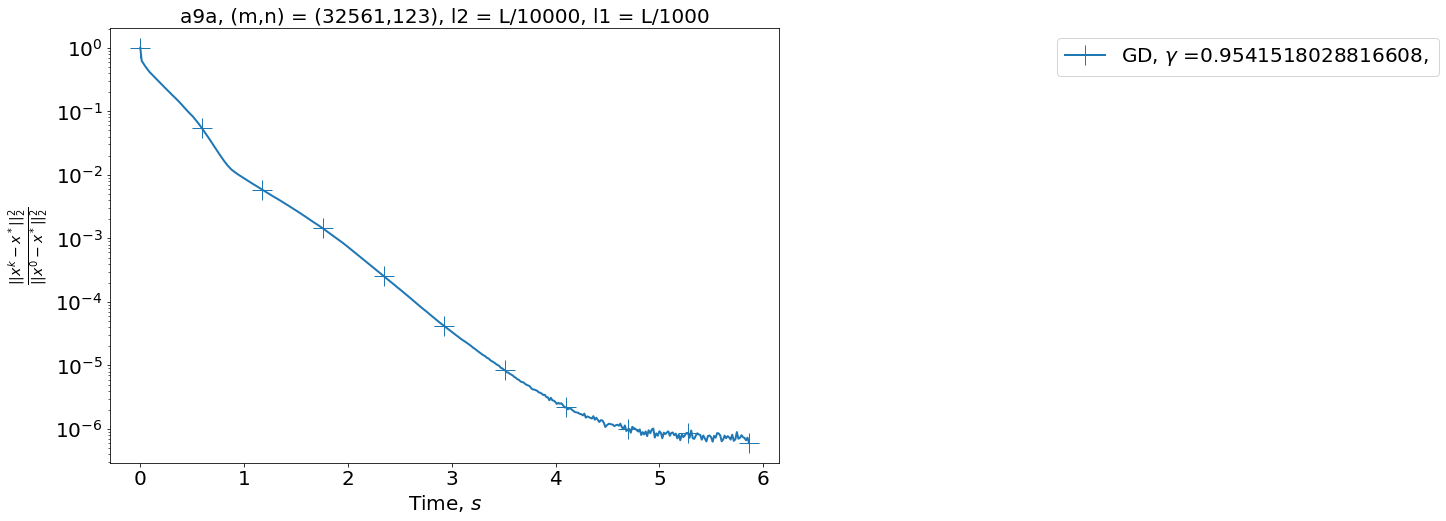

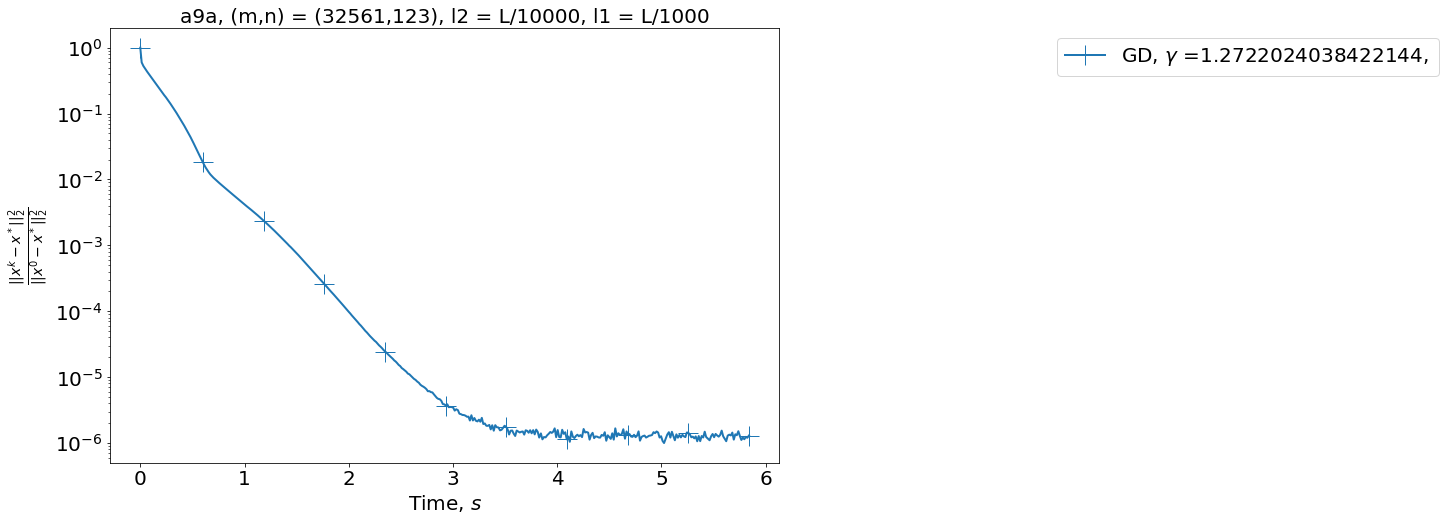

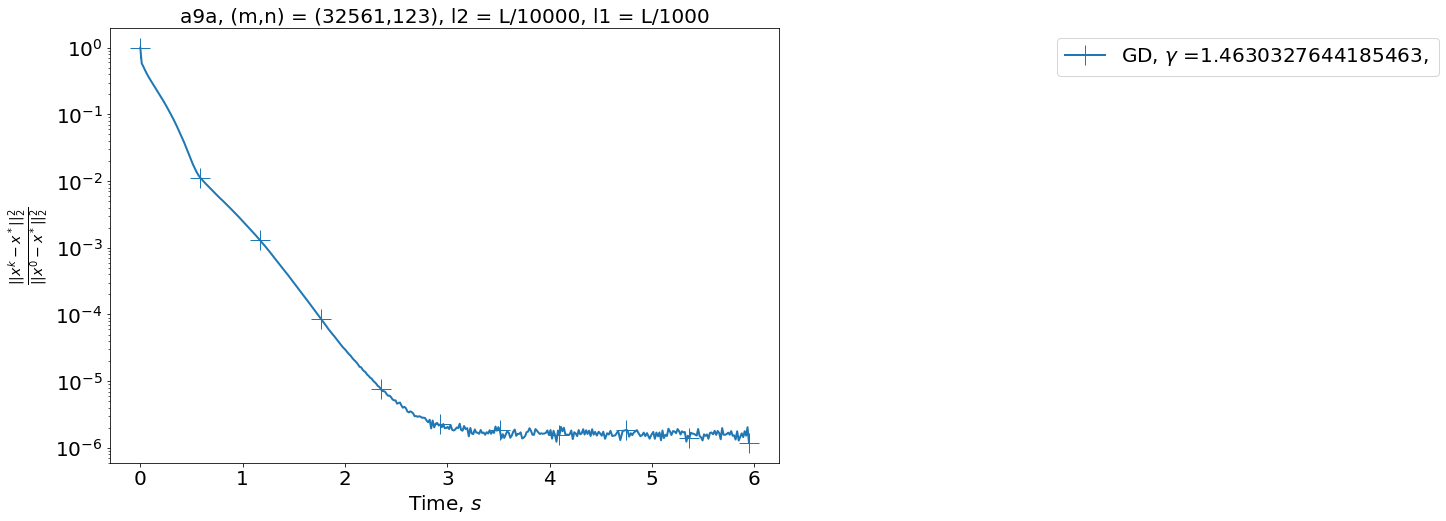

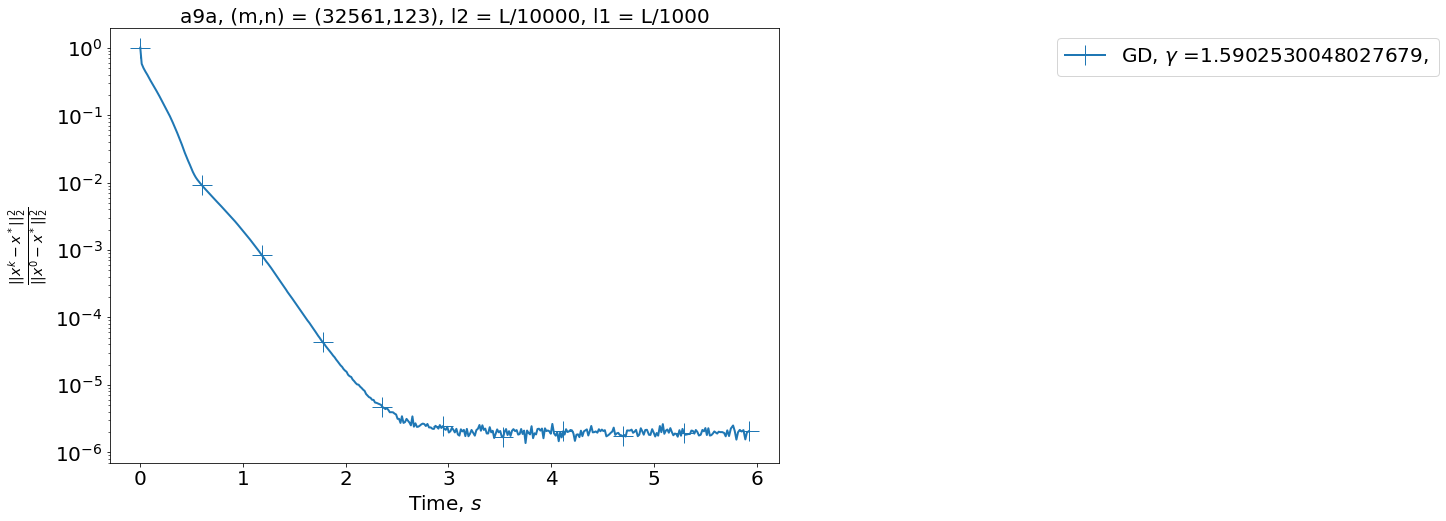

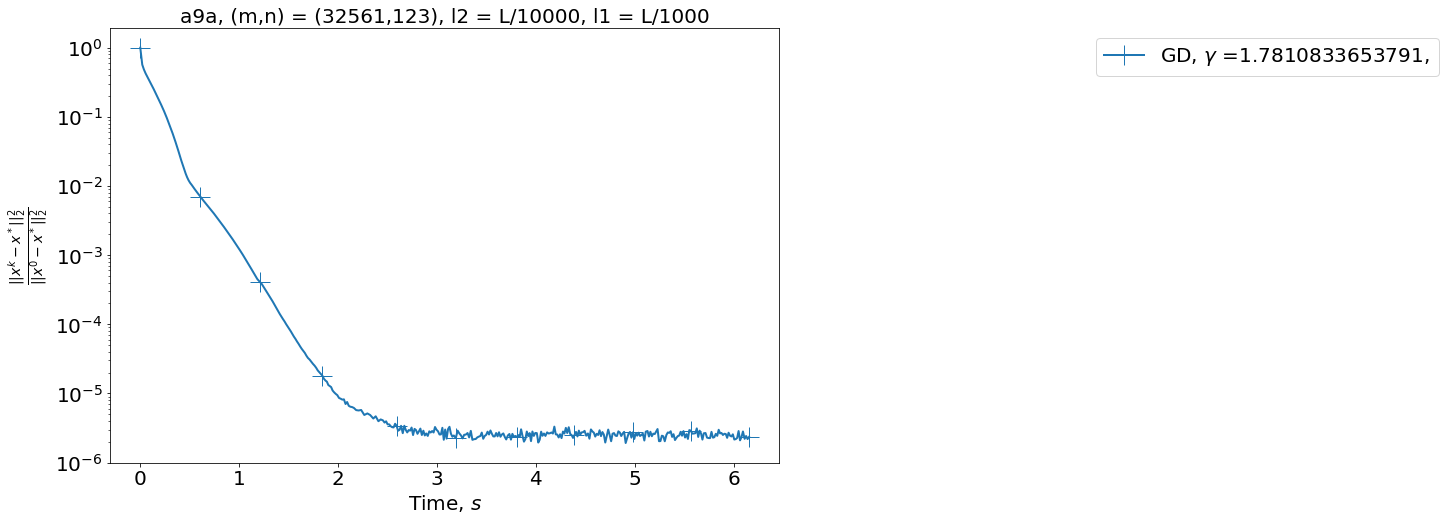

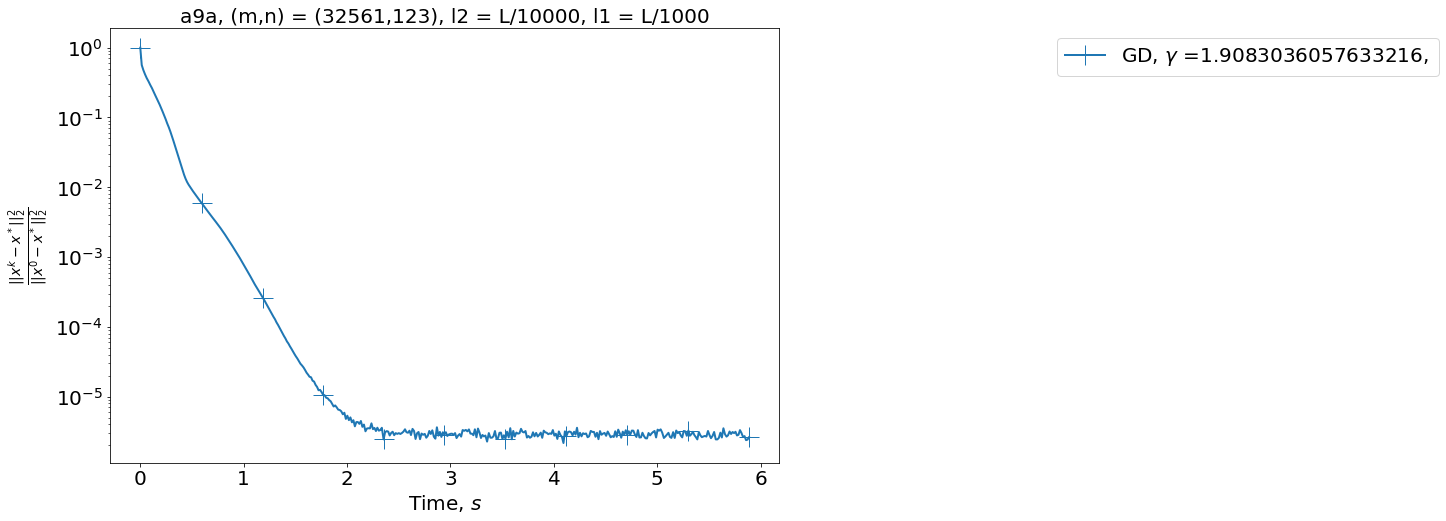

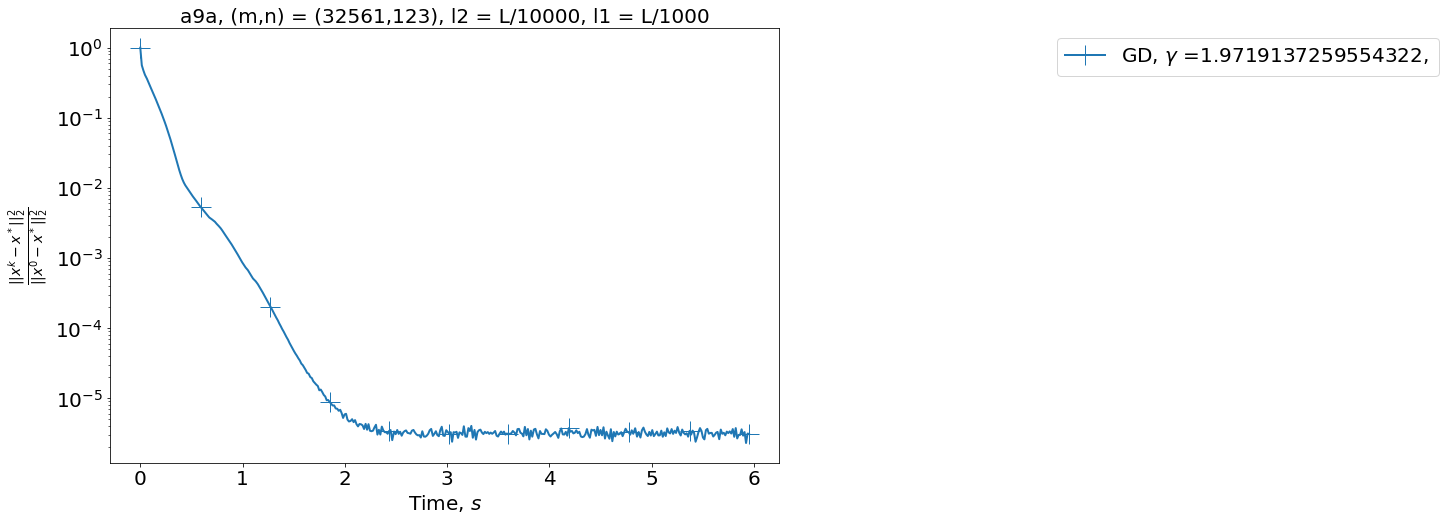

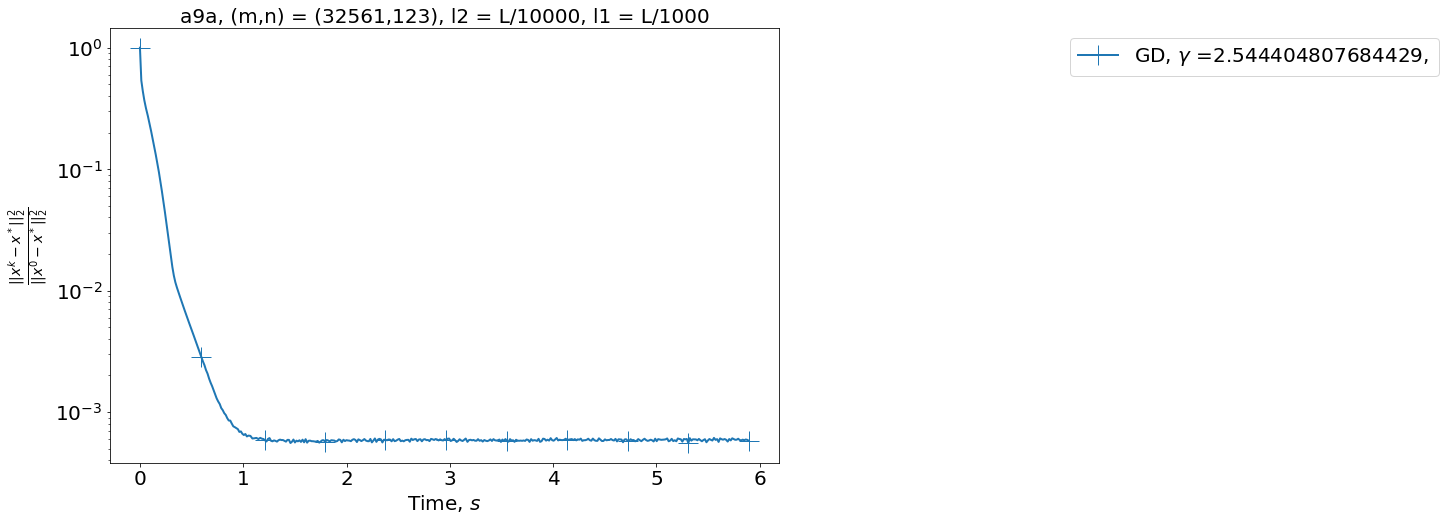

In [64]:
for gam in [0.1,0.05,1.5,2.,2.3,2.5,2.8,3,3.1,4]:
    gamma = gam/((L+l2))
    methods = [
             ['GD', [gamma,l2, l1, S], 
               f', $\gamma$ ={gamma}, ', None],
    ]
    mode_y = 'squared_distances'
    mode_x = 'time'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

Возьмем $\gamma = 1.27$

## Задание 7. Сравнение методов

## Задание 8. Эксперименты с другими датасетами

# Задача наименьших квадратов

Для удобства продублируем здесь задачу, которую мы решаем
$$
f(x) = \frac{1}{2m}\|Ax - b\|_2^2 = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\frac{1}{2}(a_i^\top x - b_i)^2}_{f_i(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$
$$
A = \begin{pmatrix}a_1^\top\\ \vdots\\ a_m^\top \end{pmatrix},\quad a_1,\ldots,a_m \in \mathbb{R}^n
$$

## Генерируем задачу

Строки матрицы выбираются случайно из стандартного нормального распределения (как и столбец $b$). Затем матрица нормируется так, что максимальное собственное число матрицы было равно единице.

In [ ]:
def construct_least_squares(m=100, n=1000):
    A = np.array([norm_d.rvs(size=n)])
    for i in range(m-1):
        A = np.row_stack((A, norm_d.rvs(size=n)))
    A /= norm(A, ord=2)
    ATA = A.T.dot(A)
    sigmas_A = svdvals(ATA)
    mu_all = sigmas_A.min() * 1.0 / m
    L_all = 1.0 / m
        
    L_max = 0
    for i in range(m):
        cut_A = A[[i]]
        sigmas = svdvals(cut_A.T.dot(cut_A))
        test_L = sigmas.max()
        if test_L > L_max:
            L_max = test_L
    
    b = norm_d.rvs(size=m)
    A_pinv = scipy.linalg.pinv(A)
    x_star = A_pinv.dot(b)
    
    f_star = least_squares_val(x_star, [A, b])
    return A, b, mu_all, L_all, L_max, x_star, f_star

In [ ]:
%%time
m = 200
n = 400
A, b, mu_all, L_all, L_max, x_star, f_star = construct_least_squares(m, n)
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

In [ ]:
max_norm = 0
for i in range(m):
    test_norm = norm(least_squares_grad(x_star, [A[[i]], b[[i]]]))
    if test_norm > max_norm:
        max_norm = test_norm
print("Максимальная норма градиента слагаемого в найденном решении: ", max_norm)

Как видим, решение, посчитанное при помощи псевдообратной матрицы, найдено очень точно

## Задание 1. SGD и SVRG

Перепишите методы $\texttt{SGD}$ с константным шагом и $\texttt{SVRG}$ (создайте новые функции, используя образцы), которые будут работать с задачей наименьших квадратов

Для начала выгрузим тестовую задачу

In [ ]:
with open("dump/test_ls_problem.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)
m, n = A.shape
print("(m,n) = (",m,",",n,")")
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

Загрузим стартовую точку

In [ ]:
with open("dump/test_starting_point.txt", 'rb') as file:
    x_init = pickle.load(file)

In [ ]:
with open("dump/indices_test_ls.txt", 'rb') as file:
    test_indices = pickle.load(file)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

In [ ]:
%%time
res = sgd_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=x_star, f_star=f_star)

In [ ]:
res['func_vals'][-1]

In [ ]:
sgd_ls_test(res)

In [ ]:
with open("dump/indices_test_ls.txt", 'rb') as file:
    test_indices = pickle.load(file)

batch_size = 1
gamma_svrg = 1.0/(6*L_max)
M = int(2 * m / batch_size)
S = 10
save_info_period = 10

In [ ]:
%%time
res = svrg_ls(x_init=x_init, A=A, b=b, gamma=gamma_svrg, S=S, M=M, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=x_star, f_star=f_star)

In [ ]:
res['func_vals'][-1]

In [ ]:
svrg_ls_test(res)

## Задание 2. SGD-star

Для начала выгрузим тестовую задачу

In [ ]:
with open("dump/test_ls_problem_2.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)
m, n = A.shape
print("(m,n) = (",m,",",n,")")
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

Загрузим стартовую точку

In [ ]:
with open("dump/test_starting_point_2.txt", 'rb') as file:
    x_init = pickle.load(file)

In [ ]:
with open("dump/indices_test_ls_2.txt", 'rb') as file:
    test_indices = pickle.load(file)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

In [ ]:
%%time
res = sgd_star_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=x_star, f_star=f_star)

In [ ]:
res['func_vals'][-1]

In [ ]:
sgd_star_ls_test(res)

## Задание 3. SLCM

Для начала выгрузим тестовую задачу

In [ ]:
with open("dump/test_ls_problem.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)
m, n = A.shape
print("(m,n) = (",m,",",n,")")
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

Загрузим стартовую точку

In [ ]:
with open("dump/test_starting_point.txt", 'rb') as file:
    x_init = pickle.load(file)

In [ ]:
with open("dump/indices_test_ls.txt", 'rb') as file:
    test_indices = pickle.load(file)

batch_size_slcm = 7
eta = 30
S_slcm = 10
save_info_period = 1

In [ ]:
%%time
res = slcm_ls(x_init=x_init, A=A, b=b, L=L_all, 
              eta=eta, S=S_slcm, batch_size=batch_size_slcm, 
              indices=test_indices, x_star=x_star, f_star=f_star)

In [ ]:
res['func_vals'][-1]

In [ ]:
slcm_ls_test(res)

## Задание 4. Эксперименты с разными матрицами

Проведите эксперименты, указанные в задании.

Постройте графики. Воспользуйтесь функциями ниже.

In [ ]:
def read_results_from_file(method, args):
    if method == 'SVRG':
        with open('dump/SVRG_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_gamma_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SGD':
        with open('dump/SGD_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_gamma_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SGD_star':
        with open('dump/SGD_star_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_gamma_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SLCM':
        with open('dump/SLCM_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_eta_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)

In [ ]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    mode_y = args[0]
    mode_x = args[1]
    figsize = args[2]
    fontsize = args[3]
    title = args[4]
    methods = args[5]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'sampled_grads':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

Пример использования функции для построения графиков

In [ ]:
methods = [
          ['SVRG', [m,n, gamma_svrg, 10, int(2*m/1), 1], 
            " текст", None],
          ['SGD', [m,n, gamma_sgd, 10, 1], 
           " текст", None],
          ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]

In [ ]:
make_plots(args_for_plots)